In [1]:
import os
import glob
import itertools
import json
import importlib

import pingouin as pg
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Import this before pandas
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.extraction.rois as rutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.objects.selectivity as sel

import analyze2p.decoding as dec

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(tick_labelsize=6, lw_axes=0.25)

In [3]:
# SET PATHS
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'
migr_prefix = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)
rootdir = rootdir.replace('/n/coxfs01', migr_prefix)
# --
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                create_new=False,
                                return_cells=True, return_missing=True,
                                rootdir=rootdir,
                                aggregate_dir=aggregate_dir)

all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
             datakey  cell
visual_area               
Li              3354  3354
Lm              4132  4132
V1              3968  3968


# Load object df

In [4]:
experiment='blobs'
trial_epoch = 'plushalf' #'stimulus'
responsive_test='ROC' #'ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
Checking mislabeled


# Output savedir

In [5]:
#aggregate_dir= '/n/coxfs01/julianarhee/aggregate-visual-areas'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
bw_area_colors={'V1': [0.7]*3, 'Lm': [0.7]*3, 'Li': [0.7]*3}
# fontsize=6
# lw=0.25
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', \
                       'selectivity_tolerance', 
                       'final', '{}-{}'.format(responsive_test, trial_epoch))
print(dst_dir)
if not os.path.exists(os.path.join(dst_dir,'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))
data_id = '%s|%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
print(data_id)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-plushalf
traces001|dff_ROC-0.05


In [7]:
## Check stimuli
SDF, incorrect_stims = aggr.check_sdfs(NDATA0['datakey'].unique(), #n_cells_all['datakey'].unique(),
                      experiment='blobs', rename=True, images_only=False,
                      return_incorrect=True, return_all=False)
print(incorrect_stims.keys())

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1', '20190306_JC061_fov3'])


In [8]:
filter_rfs = False
NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

,datakey,cell
visual_area,,
Li,584,584
Lm,1128,1128
V1,1230,1230


In [84]:
# Drop repeats
# # Get unique dkeys and count
curr_counts = NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')

# Exclude FOVs with <10 cells
min_ncells=10
enough_cells = [(k, v) for k, v in n_cells_all[n_cells_all['cell']>min_ncells]\
                [['visual_area', 'datakey']].drop_duplicates().values]
correct_stims = SDF['datakey'].unique()
# -----------------------------------
NDATA_ = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in enough_cells and dk in correct_stims])

# u_dkeys = aggr.drop_repeats(n_cells_all)
# min_ncells=10
# if filter_rfs:
#     NDATA_all = pd.concat([g for (va, dk), g in NDATA0_rf.groupby(['visual_area', 'datakey'])\
#                    if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])
# else:
#     NDATA_all = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
#                    if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])
# NDATA_all[['visual_area', 'datakey', 'cell']].drop_duplicates()\
#     .groupby('visual_area').count()

In [85]:
curr_counts = NDATA_[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
u_dkeys = aggr.drop_repeats(n_cells_all)
NDATA_all = pd.concat([g for (va, dk), g in NDATA_.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

[V1] Animalid does not exist: JC078 


### Exclude bad selectivity

In [10]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [10]:
NDATA_im = None
excl = ['20190314_JC070_fov1']
i_=[]
for (va, dk), ndf in NDATA0.groupby(['visual_area', 'datakey']):
    if dk in excl:
        continue
    sdf = aggr.get_stimuli(dk, experiment='blobs', match_names=True)
    # get mean response
    ndf['morphlevel'] = sdf.loc[ndf['config']]['morphlevel'].values
    ndf['size'] = sdf.loc[ndf['config']]['size'].values
    meanr = ndf.groupby(['cell', 'config', 'morphlevel', 'size']).mean().reset_index()\
    
    if -1 in sdf['morphlevel'].unique():
        # Exclue cells whose best stimulus is FF luminance:
        #im_df = sel.exclude_lum_is_best(ndf, sdf)
        excl_lum = sel.exclude_lum_is_best_from_mean(meanr)

        # Exclue cells that have sig. size and luminance tuning curves:
        lum_ccs = meanr.groupby(['cell']).apply(sel.get_lum_corr)
        excl_lum_corr = lum_ccs[(lum_ccs['lum_size_pval']<=0.05)
                               & (lum_ccs['lum_size_cc']>=0.5)].index
        # Get intersection:
        excl_cells = list(set(excl_lum) & set(excl_lum_corr))
        
        # Also exclude cells where responds to ALL lum stimuli
        resp_to_all_lum = []
        for c, d_ in meanr.groupby('cell'):
            if all(round(d_[d_['morphlevel']==-1]['response'], 2)>=0.1):
                resp_to_all_lum.append(c)
        # add to list
        # excl_cells.extend(resp_to_all_lum)
        print("{}: {} - Excluding {}/{} cells."\
              .format(va, dk, len(excl_cells), meanr['cell'].nunique()))
        i_.append(ndf[~ndf['cell'].isin(excl_cells)])
    else:
        i_.append(ndf)
NDATA_im = pd.concat(i_, axis=0, ignore_index=True)

Li: 20190422_JC076_fov1 - Excluding 0/29 cells.
Li: 20190602_JC091_fov1 - Excluding 11/87 cells.
Li: 20190606_JC091_fov1 - Excluding 16/48 cells.
Li: 20190607_JC091_fov1 - Excluding 2/52 cells.
Li: 20190609_JC099_fov1 - Excluding 3/60 cells.
Li: 20190612_JC099_fov1 - Excluding 6/41 cells.
Li: 20190614_JC091_fov1 - Excluding 6/78 cells.
Li: 20190617_JC099_fov1 - Excluding 1/7 cells.
Li: 20191018_JC113_fov1 - Excluding 1/47 cells.
Li: 20191111_JC120_fov1 - Excluding 0/30 cells.
Lm: 20190422_JC076_fov1 - Excluding 0/22 cells.
Lm: 20190430_JC078_fov1 - Excluding 5/98 cells.
Lm: 20190504_JC078_fov1 - Excluding 8/59 cells.
Lm: 20190506_JC080_fov1 - Excluding 9/145 cells.
Lm: 20190508_JC083_fov1 - Excluding 6/125 cells.
Lm: 20190509_JC078_fov1 - Excluding 0/43 cells.
Lm: 20190512_JC083_fov1 - Excluding 1/83 cells.
Lm: 20190513_JC078_fov1 - Excluding 4/73 cells.
Lm: 20190517_JC083_fov1 - Excluding 0/64 cells.
Lm: 20190525_JC084_fov1 - Excluding 19/91 cells.
Lm: 20190603_JC080_fov1 - Excluding 

In [11]:
lum_ccs[lum_ccs['lum_size_pval'] < 0.05]

,lum_size_cc,lum_size_pval
cell,,
100,0.912095,0.030871
152,-0.916540,0.028578
182,-0.972960,0.005316
225,0.956470,0.010831
230,-0.929670,0.022152
279,0.894794,0.040311
310,-0.984672,0.002273
383,0.902374,0.036076


In [12]:
curr_counts = NDATA_im[['visual_area', 'datakey', 'cell']].drop_duplicates()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
u_dkeys = aggr.drop_repeats(n_cells_all)
# min_ncells=10
# if filter_rfs:
#     NDATA_all = pd.concat([g for (va, dk), g in NDATA0_rf.groupby(['visual_area', 'datakey'])\
#                    if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])
# else:
NDATA_final = pd.concat([g for (va, dk), g in NDATA_im.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys]) # and len(g['cell'].unique())>=min_ncells])
NDATA_final[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

[V1] Animalid does not exist: JC078 


,datakey,cell
visual_area,,
Li,387,387
Lm,678,678
V1,1019,1019


In [71]:
min_ncells=10

curr_counts = NDATA_im[['visual_area', 'datakey', 'cell']].drop_duplicates()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')

enough_cells = [(k, v) for k, v in n_cells_all[n_cells_all['cell']>min_ncells]\
                [['visual_area', 'datakey']].drop_duplicates().values]
correct_stims = SDF['datakey'].unique()
# -----------------------------------
NDATA_ = pd.concat([g for (va, dk), g in NDATA_im.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in enough_cells and dk in correct_stims])
NDATA_[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

,datakey,cell
visual_area,,
Li,472,472
Lm,1066,1066
V1,1230,1230


In [36]:
print("Counts of all unique cells:")
print(NDATA_final[['visual_area', 'datakey', 'cell']].drop_duplicates()\
        .groupby('visual_area').count())
print("Counts of cells, min N=10 in fov:")
print(NDATA_[['visual_area', 'datakey', 'cell']].drop_duplicates()\
        .groupby('visual_area').count())
print("Counts of image-selected cells:")
print(NDATA_im[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count())

Counts of all unique cells:
             datakey  cell
visual_area               
Li               387   387
Lm               678   678
V1              1019  1019
Counts of cells, min N=10 in fov:
             datakey  cell
visual_area               
Li               310   310
Lm               622   622
V1              1019  1019
Counts of image-selected cells:
             datakey  cell
visual_area               
Li               531   531
Lm              1055  1055
V1              1214  1214


In [54]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [76]:
exclude=[] # wrong configs
remove_offset=False
offset_type = 'minsub' #'none'
global_minsub=True
lcorrection = 'exclude' #exclude' #'normalize' #'exclude' # 'exclude'
normalize = False # Divide values by 1, like for example tuning curves
filter_str = 'offset-%s_lum-%s' % (offset_type, lcorrection)
print(filter_str)
# ----------------------------------------------------------------
# ixdf = sel.aggregate_cell_metrics(NDATA_im, offset_type=offset_type, 
#                                  lcorrection=lcorrection, normalize=False)
# print(ixdf['n_cells'].min())
d_=[]
for (va, dk), x0 in NDATA_.groupby(['visual_area', 'datakey']):
    if dk in excl:
        continue
    sdf = aggr.get_stimuli(dk, experiment=experiment, match_names=True)

    configs = sdf.index.tolist()
#     if dk in SDF.keys() and x0['response'].min() < 0:
#         print("below 0: {}".format(dk))
#         break
    if remove_offset and x0['response'].min() < 0:
        x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
    if -1 not in sdf['morphlevel'].values and lcorrection!='none':
        print("    skippping, %s, %s (no lum)" % (va, dk))
        continue
    rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    # Correct offset, can be none
    rdf_offset = sel.correct_offset(rdf0, offset=offset_type, global_minsub=global_minsub)
    #rdf = correct_luminance(rdf_offset, sdf, lcorrection='exclude')
    # rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
    rdf = sel.correct_luminance_from_mean_responses(rdf_offset, sdf)
    
    if len(rdf)==0:
        continue
    ixs_ = sel.calculate_metrics(rdf[rdf.config.isin(configs)], sdf, 
                                 normalize=normalize)

    ixs_['visual_area'] = va
    ixs_['datakey'] = dk
    ixs_['n_cells'] = len(x0['cell'].unique())
    d_.append(ixs_.reset_index(drop=True))
ixdf = pd.concat(d_, axis=0, ignore_index=True)
ixdf['lum_sel'] = ixdf['lum_sel'].astype(float) #.dtypes
ixdf['lum_size_cc'] = ixdf['lum_size_cc'].astype(float) #.dtypes
ixdf['lum_size_pval'] = ixdf['lum_size_pval'].astype(float) #.dtypes

offset-minsub_lum-exclude


In [96]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [97]:
exclude=[] # wrong configs
offset_type = 'minsub'
lcorrection = 'exclude'
filter_str = 'offset-%s_lum-%s' % (offset_type, lcorrection)
print(filter_str)

NDATA = NDATA_all.copy() #0.copy() # NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
# ----------------------------------------------------------------
ixdf = sel.aggregate_cell_metrics(NDATA, offset_type=offset_type, 
                                 lcorrection=lcorrection)
print(ixdf['n_cells'].min())

offset-minsub_lum-exclude
13


In [110]:
# Get means by FOV
means_by_fov = ixdf.groupby(['visual_area', 'datakey']).median().reset_index()
ncells_by_fov = ixdf.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
fovdf = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

In [111]:
%matplotlib notebook

<IPython.core.display.Javascript object>


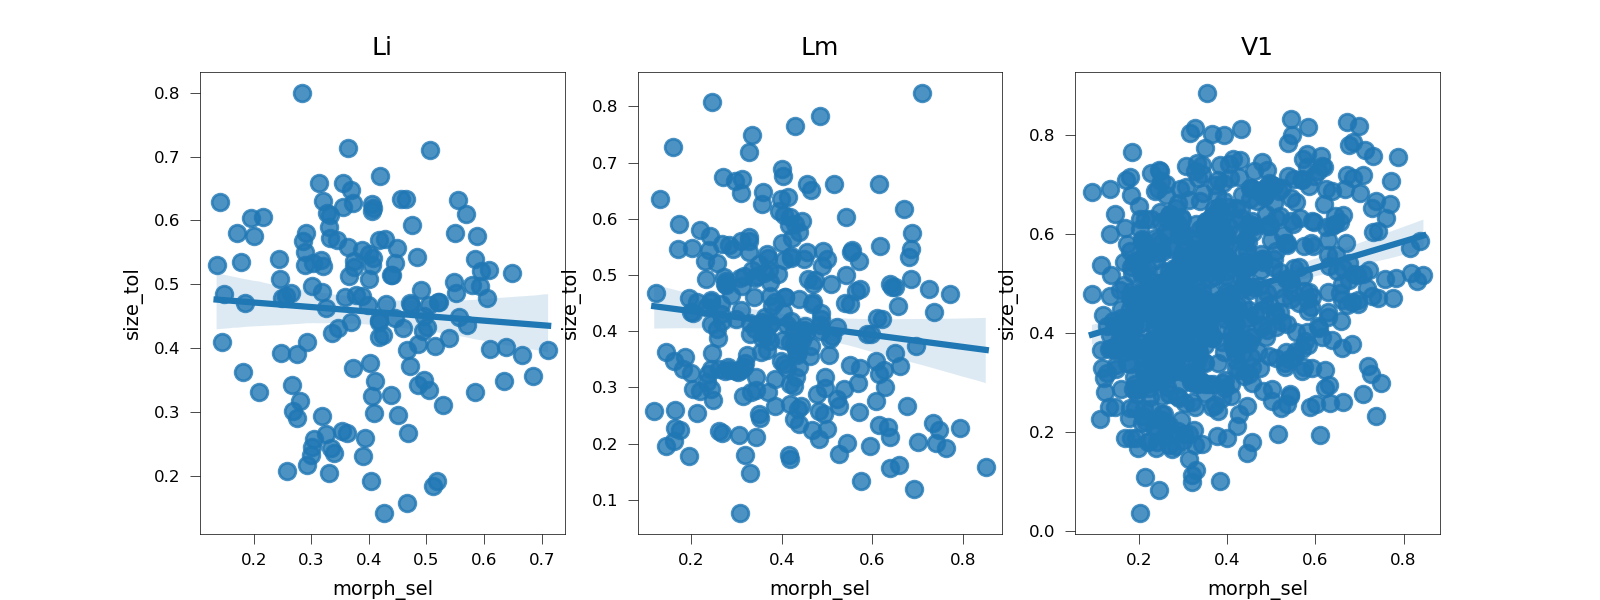

In [112]:
fig, axn =pl.subplots(1, 3, figsize=(8,3))
for ai, (va, d_) in enumerate(ixdf.groupby('visual_area')):
    ax=axn[ai]
    sns.regplot(data=d_,
                x='morph_sel', y='size_tol', ax=ax)
    ax.set_title(va)

In [113]:
ixdf.groupby('visual_area')['datakey'].nunique()

visual_area
Li    6
Lm    8
V1    9
Name: datakey, dtype: int64

<IPython.core.display.Javascript object>


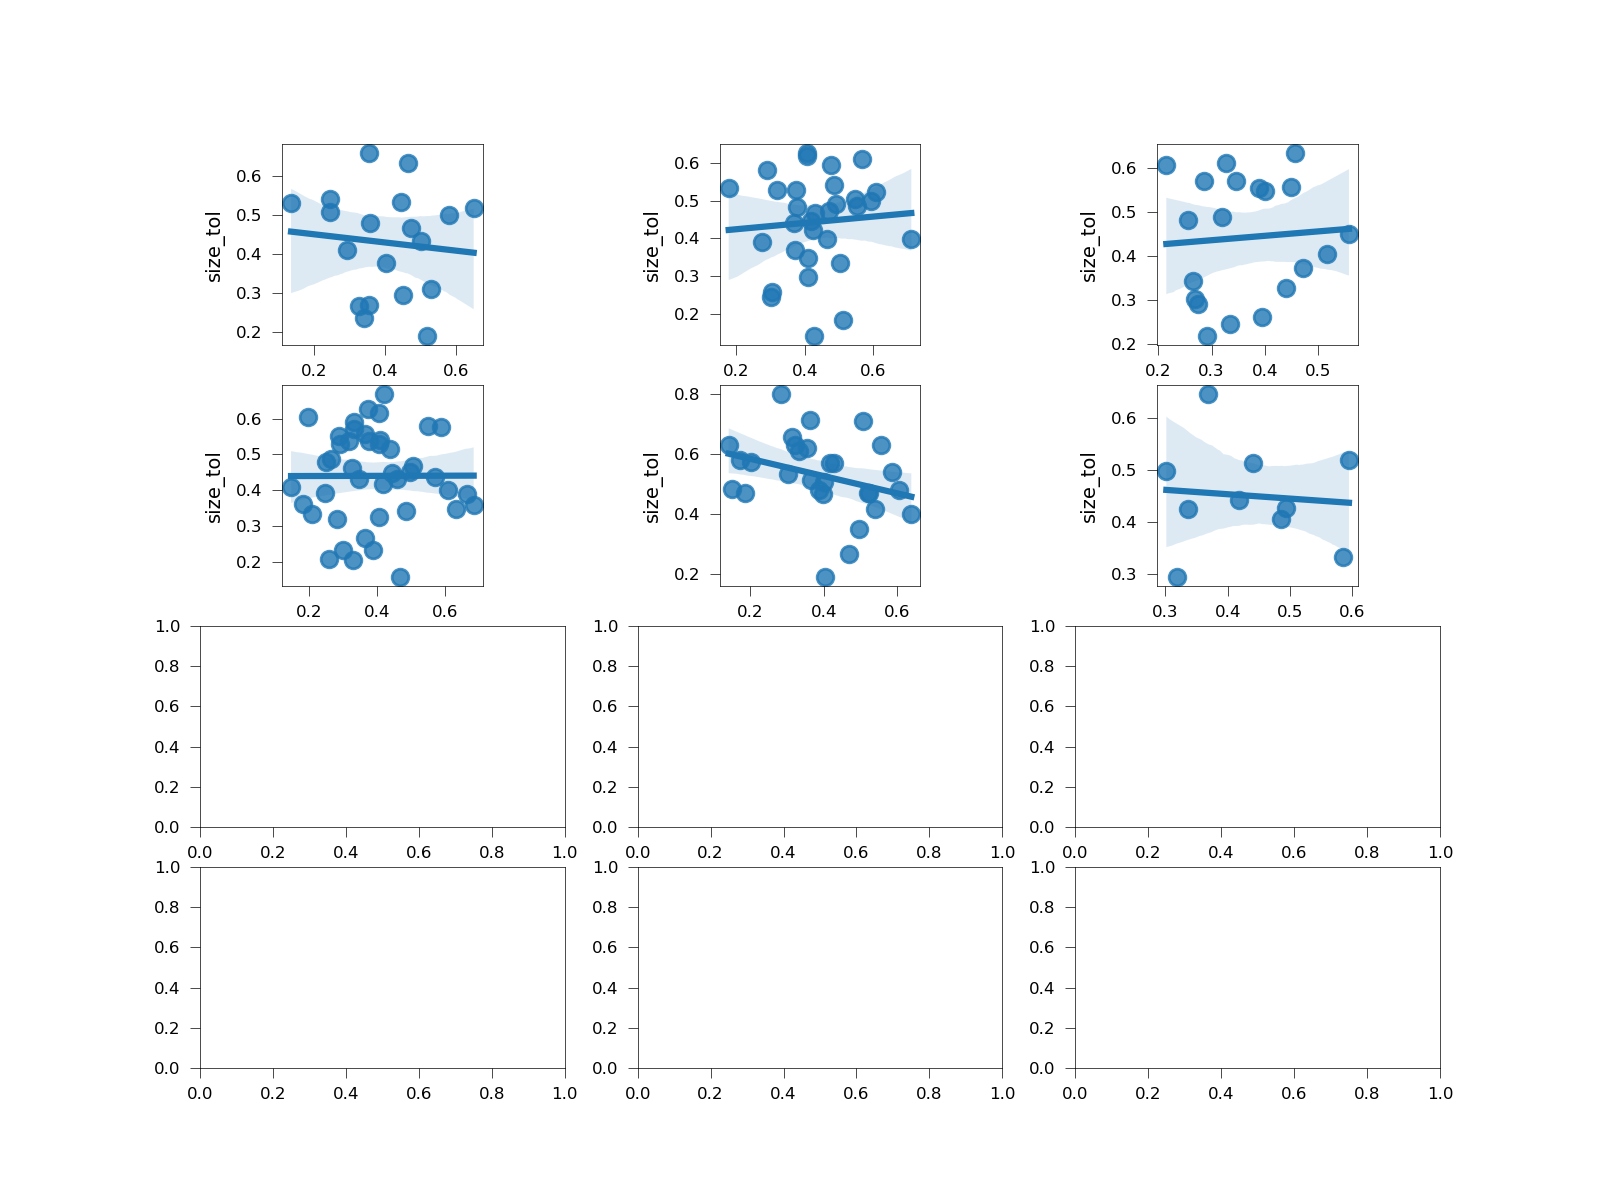

In [114]:
fig, axn =pl.subplots(4, 3, figsize=(8,6))
va = 'Li'
for ai, (dk, d_) in enumerate(ixdf[ixdf['visual_area']==va].groupby('datakey')):
    ax=axn.flat[ai]
    ax.set_box_aspect(1)
    sns.regplot(data=d_,
                x='morph_sel', y='size_tol', ax=ax)

In [115]:
r_=[]
for (va, dk), df_ in ixdf.groupby(['visual_area', 'datakey']):
    p_r, p_p = spstats.pearsonr(df_['morph_sel'], df_['size_tol'])
    res = pd.Series({'pearson_r': p_r, 'pearson_p': p_p,
               'visual_area': va, 'datakey': dk, 'n_cells': len(df_)})
    r_.append(res)
tradeoff = pd.concat(r_, axis=1, ignore_index=True).T
tradeoff['pearson_r'] = tradeoff['pearson_r'].astype(float)
tradeoff['pearson_p'] = tradeoff['pearson_p'].astype(float)

<IPython.core.display.Javascript object>


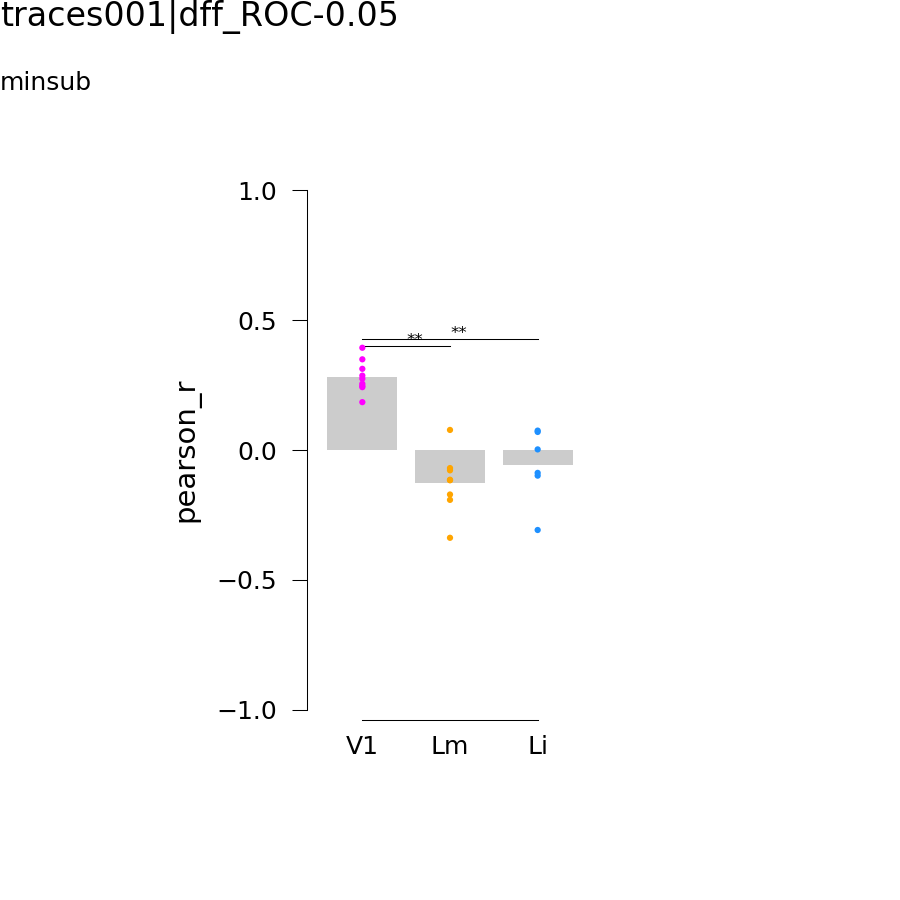

             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0 -0.06  0.14 -0.31 -0.10 -0.04  0.05  0.07
Lm             8.0 -0.13  0.12 -0.34 -0.18 -0.12 -0.08  0.08
V1             9.0  0.28  0.06  0.18  0.25  0.27  0.31  0.39
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-plushalf tradeoff-pearsonr_offset-minsub_lum-exclude_2
    A   B  p-unc  p-corr p-adjust     metric
0  V1  Lm   0.00    0.00     holm  pearson_r
1  V1  Li   0.00    0.00     holm  pearson_r
2  Lm  Li   0.34    0.34     holm  pearson_r


In [116]:
metric = 'pearson_r'
y_loc=0.4
fig, ax = pl.subplots(figsize=(3, 3), dpi=150)
ax, sts = pplot.stripplot_metric_by_area(tradeoff, metric, area_colors=area_colors,
                                markersize=3, ylim=(-1.04, 1.04), ax=ax,
                                posthoc='holm',
                                sig_fontsize=4, jitter=False, aspect=2,
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_type='mean', mean_style='bar', return_stats=True)
ax.set_yticks(np.linspace(-1, 1, 5))
print(tradeoff.groupby('visual_area')[metric].describe().round(2))
#ax.set_ylim([-0.6, 0.62])
sns.despine(trim=True, ax=ax)
pplot.label_figure(fig, data_id)
fig.text(0, 0.9, offset_type)
figname = 'tradeoff-pearsonr_%s_2' % filter_str
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
print(sts.round(2))

In [117]:
tradeoff

,pearson_r,pearson_p,visual_area,datakey,n_cells
0,-0.098750,0.687532,Li,20190422_JC076_fov1,19
1,0.074684,0.689675,Li,20190607_JC091_fov1,31
2,0.069557,0.770750,Li,20190612_JC099_fov1,20
3,0.002316,0.988242,Li,20190614_JC091_fov1,43
4,-0.308140,0.103898,Li,20191018_JC113_fov1,29
5,-0.088151,0.808662,Li,20191111_JC120_fov1,10
6,-0.078261,0.773275,Lm,20190422_JC076_fov1,16
7,-0.069635,0.776970,Lm,20190509_JC078_fov1,19
8,-0.114554,0.539464,Lm,20190513_JC078_fov1,31
9,-0.338151,0.013267,Lm,20190517_JC083_fov1,53


In [118]:
tradeoff.groupby('visual_area')['datakey'].nunique()

visual_area
Li    6
Lm    8
V1    9
Name: datakey, dtype: int64

In [157]:
means_by_fov.head()

,visual_area,datakey,morph_sel,best_size,size_tol,best_morphlevel,size_tol_corr,best_morphlevel,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell,n_cells
0,Li,20190315_JC070_fov1,0.457090,30.0,0.514536,99.0,0.209272,99.0,0.141966,0.141966,0.123041,0.485464,NaN,NaN,NaN,193.5,22.0
1,Li,20190316_JC070_fov1,0.348968,30.0,0.441162,66.0,0.112347,66.0,0.188953,0.188953,0.187041,0.558838,NaN,NaN,NaN,95.0,7.0
2,Li,20190319_JC067_fov1,0.439781,50.0,0.440624,7.0,-0.038891,7.0,0.144645,0.144645,0.232965,0.559376,NaN,NaN,NaN,167.0,2.0
3,Li,20190320_JC067_fov1,0.336570,10.0,0.542398,79.0,-0.044782,79.0,0.166618,0.166618,0.163418,0.457602,NaN,NaN,NaN,153.0,1.0
4,Li,20190321_JC070_fov1,0.460100,40.0,0.528463,106.0,-0.094265,106.0,0.129511,0.129511,0.130953,0.471537,NaN,NaN,NaN,98.0,1.0


[mean]:
  visual_area  sparseness_morphs  sparseness_total  morph_sel  size_tol  \
0          Li           0.177925          0.191095   0.394811  0.469997   
1          Lm           0.213455          0.227247   0.410993  0.418881   
2          V1           0.209454          0.227837   0.337418  0.457363   

   size_tol_corr  lum_size_cc  sparseness_morphs_std  sparseness_total_std  \
0       0.137161     0.014597               0.039435              0.024807   
1       0.165651     0.011007               0.033226              0.030095   
2       0.214584     0.120743               0.019752              0.025501   

   morph_sel_std  size_tol_std  size_tol_corr_std  lum_size_cc_std  
0       0.033231      0.034040           0.105648         0.265785  
1       0.041613      0.059000           0.064350         0.249421  
2       0.035181      0.022548           0.075939         0.209011  


<IPython.core.display.Javascript object>


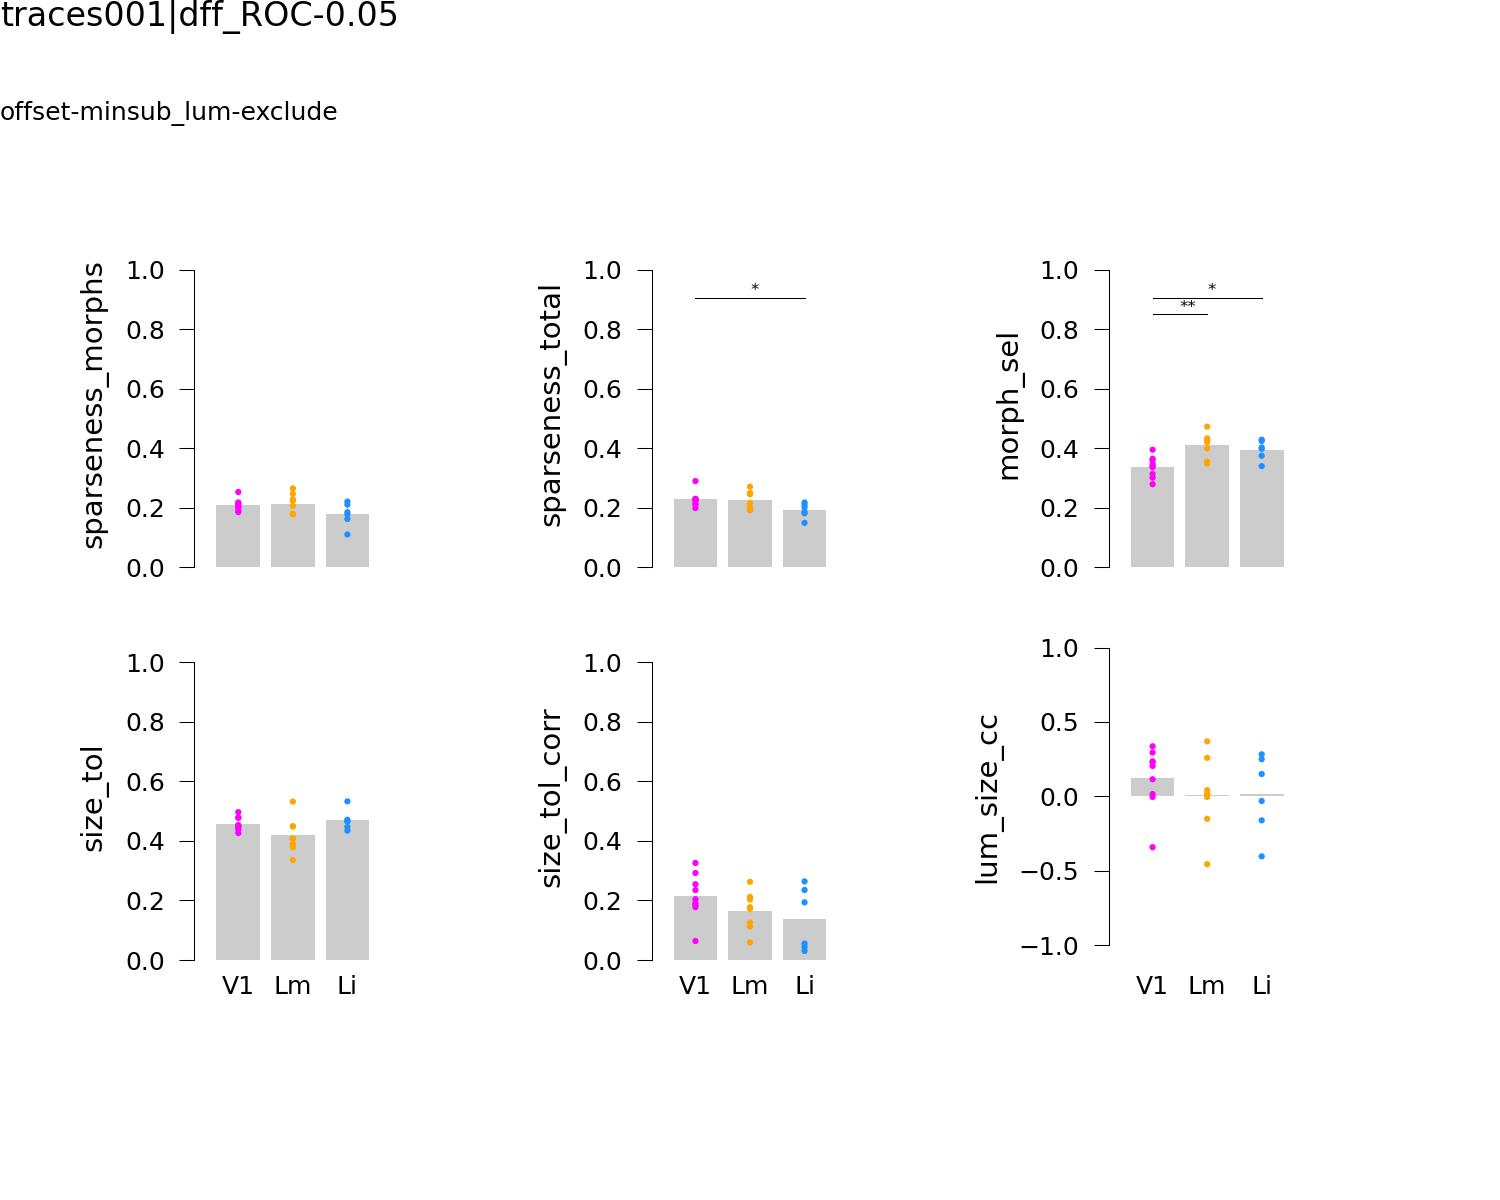

sparseness_morphs --------------
sparseness_total --------------
morph_sel --------------
size_tol --------------
size_tol_corr --------------
lum_size_cc --------------
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-plushalf metrics_byFOV_offset-minsub_lum-exclude
sparseness_morphs ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0  0.18  0.04  0.11  0.17  0.18  0.20  0.22
Lm             8.0  0.21  0.03  0.18  0.18  0.21  0.23  0.27
V1             9.0  0.21  0.02  0.19  0.20  0.21  0.21  0.25
sparseness_total ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0  0.19  0.02  0.15  0.18  0.19  0.21  0.22
Lm             8.0  0.23  0.03  0.19  0.20  0.23  0.25  0.27
V1             9.0  0.23 

In [95]:
%matplotlib notebook
plot_params=['sparseness_morphs', 'sparseness_total', 'morph_sel', 
             'size_tol', 'size_tol_corr', 'lum_size_cc']#, 
             #'lum_sel', 'lum_size_cc', , ]
mean_type='mean'
stat='mannwhitney'
multi_comp_test='fdr_bh' #'fdr_bh'
markersize = 3
fw=5
ymax=0.8 + 0.04
plotdf = fovdf.copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
                  metric=mean_type)
fig, axn = pl.subplots(2, int(np.ceil(len(plot_params)/2)), figsize=(fw, 4), 
                       sharex=True, sharey=False, dpi=150)
for ai, metric in enumerate(plot_params):
    ax=axn.flat[ai]
    ymax = np.ceil(plotdf[metric].max())*1.1
    y_loc = np.ceil(plotdf[metric].max())*0.85
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    print("{} --------------".format(metric))
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                stat=stat, posthoc=multi_comp_test,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_style='bar', mean_type=mean_type, aspect=2)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.6)
sns.despine(offset=4, trim=True, bottom=True)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byFOV_%s' % ( filter_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

for par in plot_params:
    print("%s ------------------------" % par)
    print(plotdf.groupby('visual_area')[par].describe().round(2))

In [142]:
# from scipy.stats import mannwhitneyu
# from statsmodels.stats.multitest import multipletests
# import itertools
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

## Single cell

[mean]:
  visual_area  sparseness_morphs  sparseness_total  morph_sel  size_tol  \
0          Li           0.180413          0.190376   0.419378  0.477297   
1          Lm           0.207900          0.226857   0.406386  0.432578   
2          V1           0.209288          0.226484   0.378776  0.469829   

   size_tol_corr  sparseness_morphs_std  sparseness_total_std  morph_sel_std  \
0       0.167718               0.079689              0.079969       0.134472   
1       0.151935               0.100594              0.095030       0.157488   
2       0.202039               0.099304              0.093790       0.153759   

   size_tol_std  size_tol_corr_std  
0      0.140955           0.253476  
1      0.143540           0.219443  
2      0.148520           0.256856  


<IPython.core.display.Javascript object>


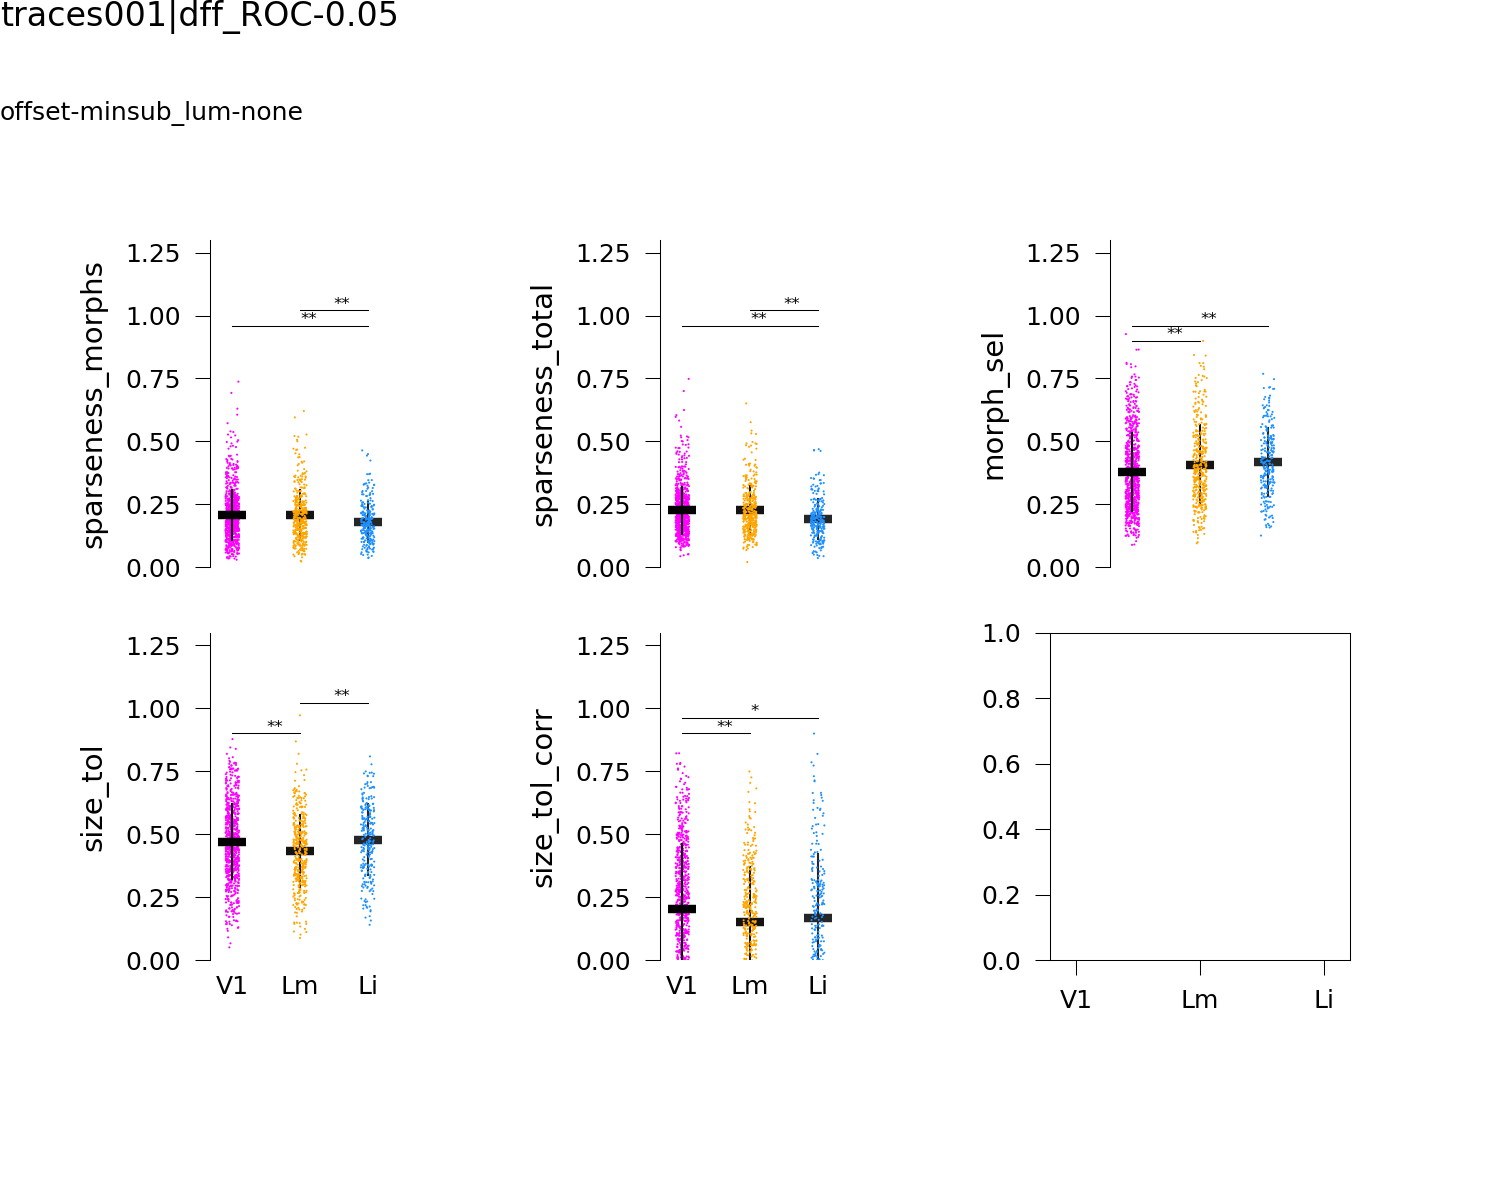

   d1  d2  reject     p_val     U_val   n1   n2
0  V1  Lm   False  0.760043  162691.0  817  394
1  V1  Li    True  0.000098  122547.0  817  256
2  Lm  Li    True  0.000887   58469.0  394  256
   d1  d2  reject         p_val     U_val   n1   n2
0  V1  Lm   False  9.151512e-01  161557.0  817  394
1  V1  Li    True  5.457391e-08  128928.0  817  256
2  Lm  Li    True  1.375073e-06   61915.0  394  256
   d1  d2  reject     p_val     U_val   n1   n2
0  V1  Lm    True  0.003213  143445.0  817  394
1  V1  Li    True  0.000012   84595.0  817  256
2  Lm  Li   False  0.079905   46335.0  394  256
   d1  d2  reject     p_val     U_val   n1   n2
0  V1  Lm    True  0.000090  184740.0  817  394
1  V1  Li   False  0.396235  100905.0  817  256
2  Lm  Li    True  0.000117   41192.0  394  256
   d1  d2  reject     p_val     U_val   n1   n2
0  V1  Lm    True  0.000928  181519.0  817  394
1  V1  Li    True  0.031310  114572.0  817  256
2  Lm  Li   False  0.618913   49268.0  394  256


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.1477136475930195, 0.14772002848141771, 0.1476949000552352)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.07356718919338619, 0.07357036712603941, 0.07355785218437204)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.0, 

NameError: name 'data_struct' is not defined

In [155]:
%matplotlib notebook
mean_type = 'mean'
multi_comp_test='fdr_bh' #'fdr_bh'

fw=5
markersize = 1 

plotdf = ixdf.copy() #dropna().copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
              metric=mean_type)
fig, axn = pl.subplots(2, int(np.ceil(len(plot_params)/2)), figsize=(fw, 4), 
                       sharex=True, sharey=False, dpi=150)
for ai, metric in enumerate(plot_params):
    ax=axn.flat[ai]
    ymax = np.ceil(plotdf[metric].max())*1.3
    y_loc = np.ceil(plotdf[metric].max())*0.9
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, aspect=2,
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_style='point', mean_type=mean_type)
    #ax.legend_.remove()
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.5)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byCELL_%s_%s_2' % (data_struct, filter_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)